# 07 Regularization Comparison

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


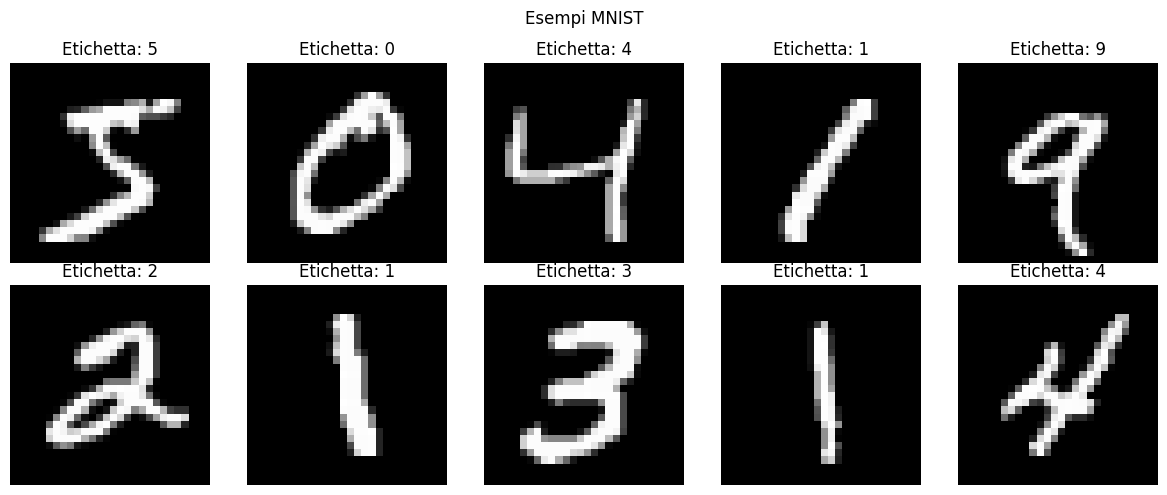

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]


### 5.6 Confronto Tecniche Anti-Overfitting

Training Baseline...
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_baseline.pt
  Baseline: 0.9744
Training Dropout...
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_dropout.pt
  Dropout: 0.9744
Training L2 Regularization...
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_l2_reg.pt
  L2 Regularization: 0.9702
Training Batch Normalization...
Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_batchnorm.pt
  Batch Normalization: 0.9776

Confronto Tecniche:
            Modello  Test Accuracy
Batch Normalization         0.9776
           Baseline         0.9744
            Dropout         0.9744
  L2 Regularization         0.9702


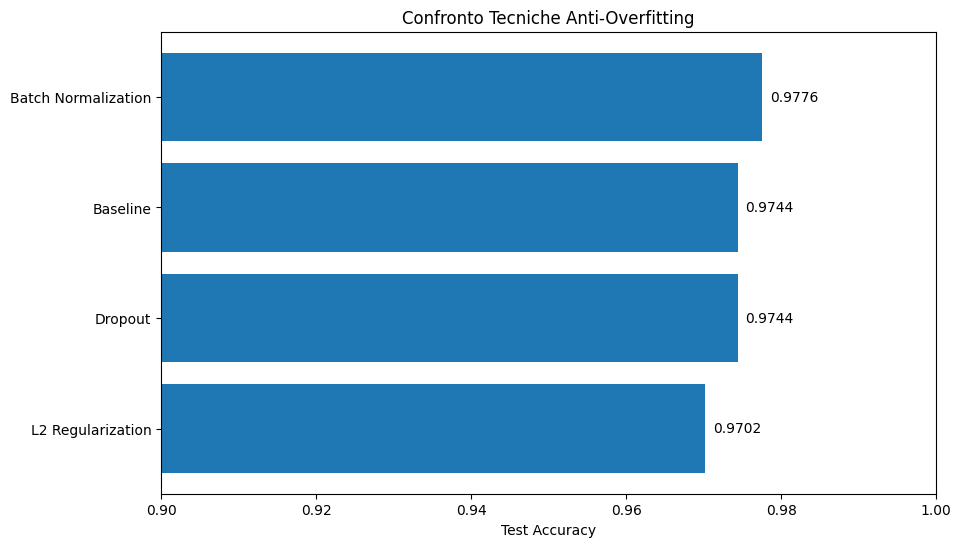

In [16]:
# Training da zero per confronto equo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_model_multiclass(model, X_train_np, y_train_np, epochs=10, batch_size=128, val_split=0.2, weight_decay=0.0):
    """Helper function per training modelli multiclasse."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    X_t = torch.FloatTensor(X_train_np).to(device)
    y_t = torch.LongTensor(y_train_np).to(device)

    n_val = int(len(X_t) * val_split)
    idx = torch.randperm(len(X_t))
    X_tr, y_tr = X_t[idx[n_val:]], y_t[idx[n_val:]]
    X_vl, y_vl = X_t[idx[:n_val]], y_t[idx[:n_val]]

    train_ds = TensorDataset(X_tr, y_tr)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for bx, by in loader:
            optimizer.zero_grad()
            out = model(bx)
            loss = criterion(out, by)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * bx.size(0)
            _, predicted = torch.max(out, 1)
            total += by.size(0)
            correct += (predicted == by).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        with torch.no_grad():
            val_out = model(X_vl)
            val_loss = criterion(val_out, y_vl).item()
            _, val_pred = torch.max(val_out, 1)
            val_acc = (val_pred == y_vl).sum().item() / len(y_vl)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

    return history

def evaluate_model(model, X_np, y_np):
    """Valuta un modello e ritorna accuracy."""
    model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(X_np).to(device)
        y_t = torch.LongTensor(y_np).to(device)
        out = model(X_t)
        _, pred = torch.max(out, 1)
        acc = (pred == y_t).sum().item() / len(y_t)
    return acc

# Ricreo tutti i modelli da zero
model_baseline_new = nn.Sequential(
    nn.Linear(784, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

model_dropout_new = nn.Sequential(
    nn.Linear(784, 128), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(64, 10)
).to(device)

model_reg_new = nn.Sequential(
    nn.Linear(784, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

model_bn_new = nn.Sequential(
    nn.Linear(784, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.3),
    nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.3),
    nn.Linear(64, 10)
).to(device)

# Training con stesse condizioni (with pretrained weight support)
EPOCHS = 10
risultati = []

models_compare = {
    'Baseline': (model_baseline_new, 0.0, 'nb04_baseline.pt'),
    'Dropout': (model_dropout_new, 0.0, 'nb04_dropout.pt'),
    'L2 Regularization': (model_reg_new, 0.001, 'nb04_l2_reg.pt'),
    'Batch Normalization': (model_bn_new, 0.0, 'nb04_batchnorm.pt')
}

for nome, (modello, wd, wf) in models_compare.items():
    print(f'Training {nome}...')
    load_or_train(
        modello,
        lambda m=modello, w=wd: train_model_multiclass(m, X_train_norm, y_train, epochs=EPOCHS, weight_decay=w),
        wf,
        device=device,
    )
    test_acc = evaluate_model(modello, X_test_norm, y_test)
    risultati.append({
        'Modello': nome,
        'Test Accuracy': test_acc
    })
    print(f'  {nome}: {test_acc:.4f}')

# Confronto risultati
df_risultati = pd.DataFrame(risultati).sort_values(
    'Test Accuracy', ascending=False
)
print("\nConfronto Tecniche:")
print(df_risultati.to_string(index=False))

# Visualizzazione
plt.figure(figsize=(10, 6))
plt.barh(
    df_risultati['Modello'],
    df_risultati['Test Accuracy']
)
plt.xlabel('Test Accuracy')
plt.title('Confronto Tecniche Anti-Overfitting')
plt.xlim([0.9, 1.0])
for i, v in enumerate(df_risultati['Test Accuracy']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center')
plt.gca().invert_yaxis()
plt.show()